In [183]:
from random import randint
import random
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

random.seed(0)

# Part 1

### 1a

A binomial distribution is observed. This is because there are $n-1 \choose d$ ways to choose $d$ vertices among $n-1$ nodes (we exclude self-connections). Each node has $p^d$ probability of connecting to $d$ vertices. Since these must be no edges to the remaining $n-1-d$ nodes which occur with probability $(1-p)^{n-1-d}$ we get the probability that 2 nodes are connected as $Prob[d] = {n-1\choose d} p^d (1-p)^{n-1-d}$. Since $n$ is sufficiently large $n-1\approx n$

   Theoretical Mean  Calc Mean  Theoretical Variance  Calc Variance
0             1.798   1.773333              1.794404       1.730844
1             5.394   5.382222              5.361636       5.425017
2            10.788  10.706667             10.658544      10.965067
3            40.455  40.591111             38.634525      38.128365
4            89.900  90.017778             80.910000      84.841906


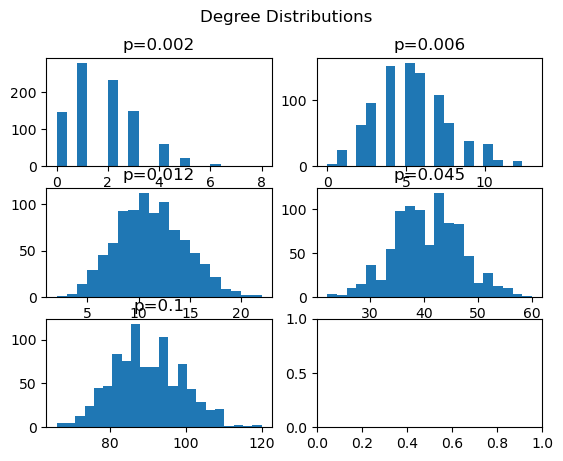

In [3]:
# 1a
# create an undirected random network
n_nodes = 900
probabilities = [0.002, 0.006, 0.012, 0.045, 0.1] # prob that edge exists b/w 2 vertices

fig, axs = plt.subplots(3, 2)
fig.suptitle('Degree Distributions')
theor_means = []
theor_vars = []
calc_means = []
calc_vars = []
graphs = []

for p, ax in zip(probabilities, axs.reshape(-1)):
    graph = ig.Graph.Erdos_Renyi(n=n_nodes, p=p, directed=False, loops=False)
    graphs.append(graph)
    degrees = [v.degree() for v in graph.vs]

    # Theoretical mean and variance of degree distribution
    # we use (n-1) since a node can't connect to itself
    # Erdos-Renyi Graph follows a binomial distribution. These are binomial mean/var from wikipedia
    # https://chih-ling-hsu.github.io/2020/05/15/Gnp
    # https://www.cs.cmu.edu/~avrim/598/chap4only.pdf
    theor_means.append((n_nodes-1)*p)
    theor_vars.append((n_nodes-1)*p*(1-p))
    calc_means.append(np.mean(degrees))
    calc_vars.append(np.var(degrees))

    ax.hist(degrees, bins='auto')
    ax.title.set_text(f'p={p}')

print(pd.DataFrame({
    "Theoretical Mean": theor_means, 
    "Calc Mean": calc_means, 
    "Theoretical Variance": theor_vars, 
    "Calc Variance": calc_vars
}))

### 1b

In [4]:
n_iter = 1000

for p, g in zip(probabilities, graphs):
    out_str = f'p={p}, connected={g.is_connected()}'

    # Numerically estimate the probability that a generated network is connected
    connected = 0
    for i in range(n_iter):
        graph = ig.Graph.Erdos_Renyi(n=n_nodes, p=p, directed=False, loops=False)
        connected += graph.is_connected()
    prob_connected = connected/n_iter
    out_str += f', prob_connected={prob_connected}'

    # if a graph is not connected estimate the diameter of the giant component
    if not g.is_connected():
        g = g.connected_components().giant()
        out_str += f', diameter={g.diameter()}'
    print(out_str)

p=0.002, connected=False, prob_connected=0.0, diameter=24
p=0.006, connected=False, prob_connected=0.016, diameter=9
p=0.012, connected=True, prob_connected=0.986
p=0.045, connected=True, prob_connected=1.0
p=0.1, connected=True, prob_connected=1.0


### 1c

i) Emergence starts to show growth similar to an exponential around p=0.0011 which matches  
the np=1 threshold for significantly large connected components from the Erdos-Renyi Paper  
ii) p=0.0066


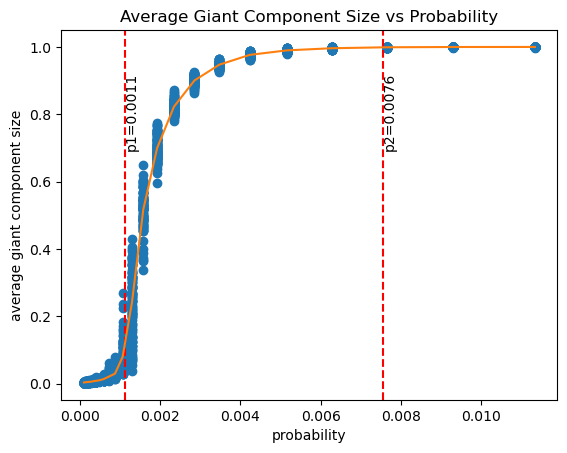

In [5]:
# Edit these values
epsilon = 0.5 # vary this value between 0 and 1
n_p_values = 25 # number of p values to test, log-spaced
n_iter = 100 # number of iterations for each p value to average over

# Don't edit these values
n = 900
p1 = 1/n
p2 = np.log(n)/n
p_max = (1+epsilon)*p2 # graph is almost surely connected if p > p_max
probabilities = np.logspace(-4, np.log10(p_max), n_p_values)
avg_gcc_vals = np.empty(n_p_values)

for i, p in enumerate(probabilities):
    gcc_values = np.empty(n_iter)
    for j in range(n_iter):
        graph = ig.Graph.Erdos_Renyi(n=n, p=p, directed=False, loops=False)
        gcc_values[j] = graph.connected_components().giant().vcount()/n
    avg_gcc_vals[i] = np.average(gcc_values)
    plt.scatter(n_iter*[p], gcc_values, color='#1f77b4')

plt.xlabel('probability')
plt.ylabel('average giant component size')
plt.title('Average Giant Component Size vs Probability')
plt.axvline(x=p1, color='r', linestyle='--')
plt.text(p1, 0.7, f'p1={round(p1, 4)}', rotation=90)
plt.axvline(x=p2, color='r', linestyle='--')
plt.text(p2, 0.7, f'p2={round(p2, 4)}', rotation=90)
plt.plot(probabilities, avg_gcc_vals, color="#ff7f0e")

### 1d

In [6]:
def expected_gcc_size(c, n_iter = 150, n_node_values = 20):
    n_nodes = np.logspace(2, 4, n_node_values, dtype=int)
    avg_gcc_sizes = np.empty(n_node_values)
    for i, n in enumerate(n_nodes):
        for _ in range(n_iter):
            graph = ig.Graph.Erdos_Renyi(n=n, p=c/n, directed=False, loops=False)
            avg_gcc_sizes[i] += graph.connected_components().giant().vcount()/n_iter
    return n_nodes, avg_gcc_sizes

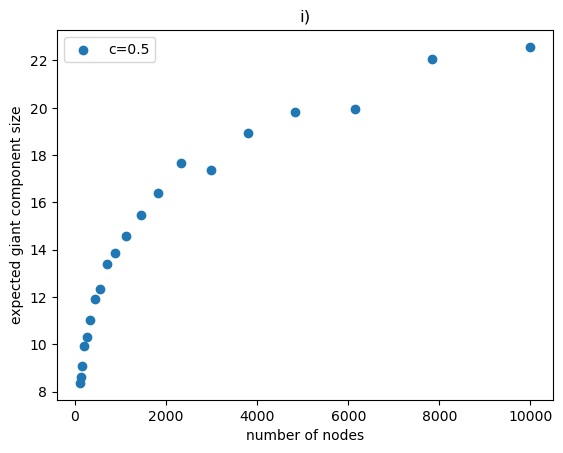

In [7]:
plt.scatter(*expected_gcc_size(0.5), label='c=0.5')
plt.xlabel('number of nodes')
plt.ylabel('expected giant component size')
plt.title('i)')
plt.legend()

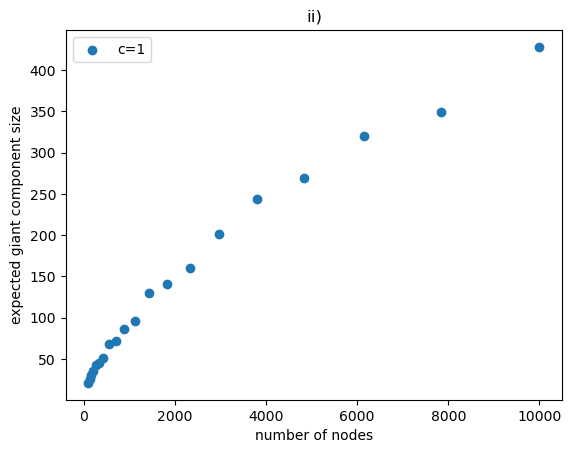

In [8]:
plt.scatter(*expected_gcc_size(1), label='c=1')
plt.xlabel('number of nodes')
plt.ylabel('expected giant component size')
plt.title('ii)')
plt.legend()

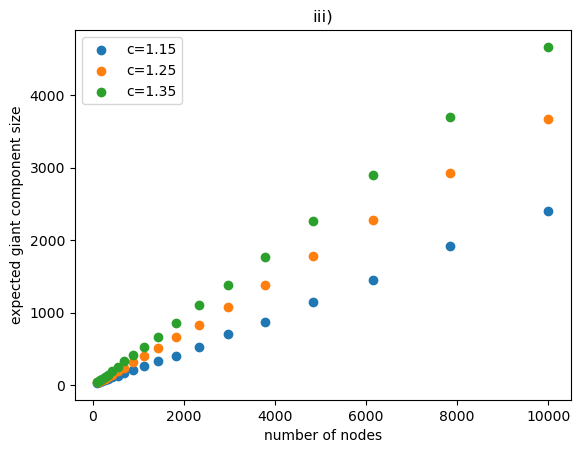

In [9]:
plt.scatter(*expected_gcc_size(1.15), label='c=1.15')
plt.scatter(*expected_gcc_size(1.25), label='c=1.25')
plt.scatter(*expected_gcc_size(1.35), label='c=1.35')
plt.xlabel('number of nodes')
plt.ylabel('expected giant component size')
plt.title('iii)')
plt.legend()

iv)  
c=0.5 shows a logarithmic trend  
c=1 shows a logarithmic trend moving into eing a linear trend  
c=1.15, 1.25, 1.35 shows a linear trend

### 2a
The network is always connected as mentioned in lecture 3 or 4, "Also , by construction, networks created using preferential attachment model are connected"

In [27]:
g1 = ig.Graph.Barabasi(n=1050, m=1, directed=False, outpref=False)

### 2b
Assortativity is the tendency of nodes in a network to connect to other similar nodes

In [28]:
communities = g1.community_fastgreedy().as_clustering()
print(f'Fast Greedy Modularity: {communities.modularity}')
print(f'Assortativity: {g1.assortativity_degree(directed=False)}')

Fast Greedy Modularity: 0.9343071298553891
Assortativity: -0.07970700487040337


### 2c

In [26]:
g2 = ig.Graph.Barabasi(n=10500, m=1, directed=False, outpref=False)
communities = g2.community_fastgreedy().as_clustering()
print(f'Fast Greedy Modularity: {communities.modularity}')
print(f'Assortativity: {g2.assortativity_degree(directed=False)}')

Fast Greedy Modularity: 0.9789519638302808
Assortativity: -0.042727555361091005


### 2d
Slopes:  
n = 1050, slope = -3.03  
n = 10500, slope = -3.64

C:\Users\Hersh\AppData\Local\Temp\ipykernel_5208\32896964.py:16: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)
C:\Users\Hersh\AppData\Local\Temp\ipykernel_5208\32896964.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = np.linalg.lstsq(np.vstack([log_bins, np.ones(len(log_bins))]).T, log_hist)[0]
C:\Users\Hersh\AppData\Local\Temp\ipykernel_5208\32896964.py:23: RuntimeWarning: divide by zero encountered in log
  ax.plot(bins, np.exp(X[0]*np.log(bins) + X[1]))


n_nodes=1050, Slope:  -3.034681853723198
n_nodes=10500, Slope:  -3.6438661484228616


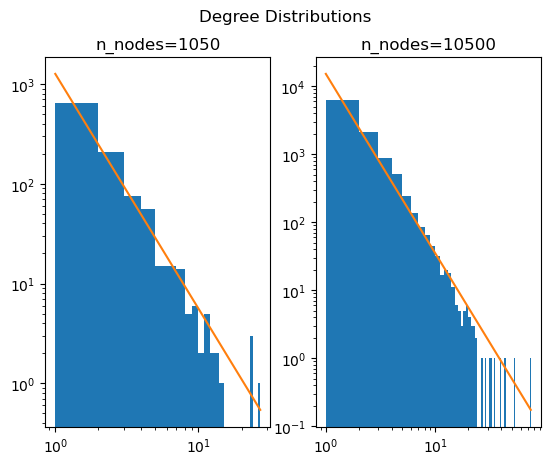

In [71]:
n_nodes = [1050, 10500]
fig, axs = plt.subplots(1, 2)
fig.suptitle('Degree Distributions')
graphs = [g1, g2]

for n, ax, g in zip(n_nodes, axs.reshape(-1), graphs):
    degrees = [v.degree() for v in g.vs]
    bins = np.arange(max(degrees)+1)
    hist = ax.hist(degrees, bins=bins)[0]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.title.set_text(f'n_nodes={n}')

    # Linear Regression
    log_bins = np.log(np.arange(0.5, max(degrees)+0.5))
    log_hist = np.log(hist)
    equal_neg_inf = np.isneginf(log_bins) | np.isneginf(log_hist)
    log_bins = log_bins[~equal_neg_inf]
    log_hist = log_hist[~equal_neg_inf]
    
    X = np.linalg.lstsq(np.vstack([log_bins, np.ones(len(log_bins))]).T, log_hist)[0]
    print(f"n_nodes={n}, Slope: ", X[1]/X[0])
    ax.plot(bins, np.exp(X[0]*np.log(bins) + X[1]))

### 2e
No, through re-running the model it appears to follow more of Poisson style distribution. The peak is not at the lowest bin but at the 2nd bin even after re-running the sampling many times.

If a first degree polynomial is fit to the model it follows:
For n=1050 the slope decreases from -3.03 to -5.03  
For n=10500 the slope stays the same (-3.64) 

C:\Users\Hersh\AppData\Local\Temp\ipykernel_5208\238897502.py:21: RuntimeWarning: divide by zero encountered in log
  log_hist = np.log(hist)
C:\Users\Hersh\AppData\Local\Temp\ipykernel_5208\238897502.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X = np.linalg.lstsq(np.vstack([log_bins, np.ones(len(log_bins))]).T, log_hist)[0]
C:\Users\Hersh\AppData\Local\Temp\ipykernel_5208\238897502.py:28: RuntimeWarning: divide by zero encountered in log
  ax.plot(bins, np.exp(X[0]*np.log(bins) + X[1]))


n_nodes=1050, Slope:  -3.932049085034262
n_nodes=10500, Slope:  -3.795447023644634


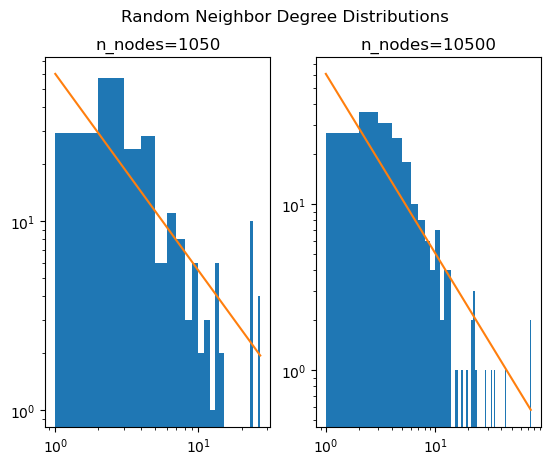

In [173]:
n_nodes = [1050, 10500]
fig, axs = plt.subplots(1, 2)
fig.suptitle('Random Neighbor Degree Distributions')
graphs = [g1, g2]

for n, ax, g in zip(n_nodes, axs.reshape(-1), graphs):
    sample = np.random.choice(g.vs, size=200, replace=True)
    degrees = []
    for v in sample:
        neighbors = v.neighbors()
        degrees.append(neighbors[randint(0, len(neighbors)-1)].degree())

    bins = np.arange(max(degrees)+1)
    hist = ax.hist(degrees, bins=bins)[0]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.title.set_text(f'n_nodes={n}')

    # Linear Regression
    log_bins = np.log(np.arange(0.5, max(degrees)+0.5))
    log_hist = np.log(hist)
    equal_neg_inf = np.isneginf(log_bins) | np.isneginf(log_hist)
    log_bins = log_bins[~equal_neg_inf]
    log_hist = log_hist[~equal_neg_inf]
    
    X = np.linalg.lstsq(np.vstack([log_bins, np.ones(len(log_bins))]).T, log_hist)[0]
    print(f"n_nodes={n}, Slope: ", X[1]/X[0])
    ax.plot(bins, np.exp(X[0]*np.log(bins) + X[1]))

2a. the probability of attaching to a node is based on the number of edges it has. a hexagon with a point in the middle has a probability of 6/12 of connected to the center node p = degree(v)/(2nm) so probably degree(v)/|E|. Follows the 

All nodes in a preferential attachment model are connected

2b. Can find densly connected clusters called a community. Modularity is how easy you can find a community. If we can easily cluster a group it has a high modularity. Assortativity will be given in lecture, but it is something to do with a vertex. 

2c. 
2d. 
2e. generate model multiple times in order to get the degree distribution. can also do by hand
2f. 
2g. repeat previous part but with different values of n
2h. 

------------------

3a. also need to consider age of old nodes (ie order in which node is generated). $P(m) = P[i] ~ (ck^a_i+a)(dl^\beta_i+b)$
3b. 


Ask question about how early ot work in project ditching class and watching lectures


### 2f

Text(0, 0.5, 'average degree')

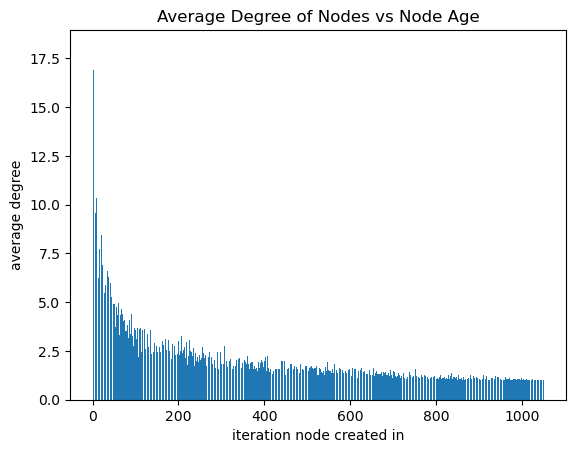

In [200]:
n_nodes = 1050
node_avg_degree = np.zeros(n_nodes)

n_iters = 20
for _ in range(n_iters):
    g = ig.Graph.Barabasi(n=1050, m=1, directed=False, outpref=False)
    for i, v in enumerate(g.vs):
        node_avg_degree[i] += v.degree()/n_iters

plt.bar(np.arange(1, n_nodes+1), node_avg_degree)
plt.title('Average Degree of Nodes vs Node Age')
plt.xlabel('iteration node created in')
plt.ylabel('average degree')

### 2g
The average degree of older nodes increases as m increases.  
For a node of a node created in iteration 500, the average degree for m=1 is 2.5, for m=2 it is ~5, and for m=6 it is ~20. The trend is even greater for iteraetion 1 where the average degree is around 17, 44, and 90 respectively.

Text(0.5, 0.98, 'Average Degree of Nodes vs Node Age')

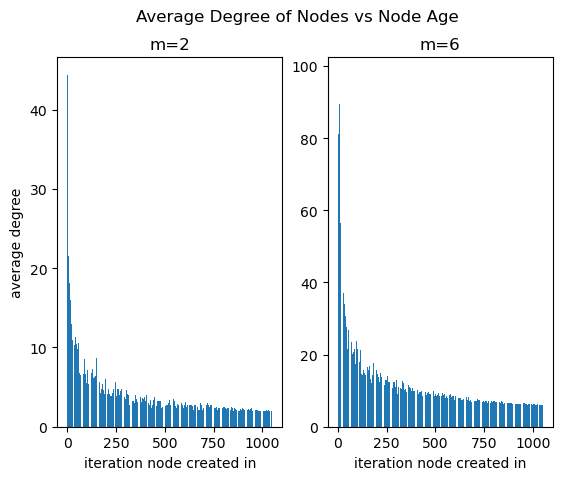

In [201]:
n_nodes = 1050
n_iters = 10
fig, axs = plt.subplots(1, 2)
axs[0].set_ylabel('average degree')

for m, ax in zip([2, 6], axs.reshape(-1)):
    node_avg_degree = np.zeros(n_nodes)
    for _ in range(n_iters):
        g = ig.Graph.Barabasi(n=1050, m=m, directed=False, outpref=False)
        for i, v in enumerate(g.vs):
            node_avg_degree[i] += v.degree()/n_iters
    ax.bar(np.arange(1, n_nodes+1), node_avg_degree)
    ax.set_xlabel('iteration node created in')
    ax.set_title(f'm={m}')

plt.suptitle('Average Degree of Nodes vs Node Age')

### 2h

### 3a

### 3b

# Part 2

### 1a

### 1b

### 1c

### 1d

### 2a

### 2b

### 2c

### 2d

### 3a

### 3b

### 4a

### 4b

### 4c